In [2]:
# Utilities
import os
from glob import glob

# Algebra
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

# Neural Networks
import tensorflow as tf
from tensorflow import keras as ks

# Satellite images segmentation

The task consists of creating a neural model able to perform semantic segmentation on satellite images into six (seven with the no information) different classes. The data used in this project is extracted from the [IGN](https://geoservices.ign.fr/telechargement) archives, and can be downloaded [here](https://drive.google.com/file/d/1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem/view?usp=sharing).

Each tile in the dataset has a 1000x1000 resolution representing a 500m x 500m footprint (the resolution is 50cm per pixel).

The file structure of the dataset is as follows:
```none
├── ign
│   ├── annotations
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png
│   ├── images
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png

```

Here is an example of the image/mask contained in the dataset: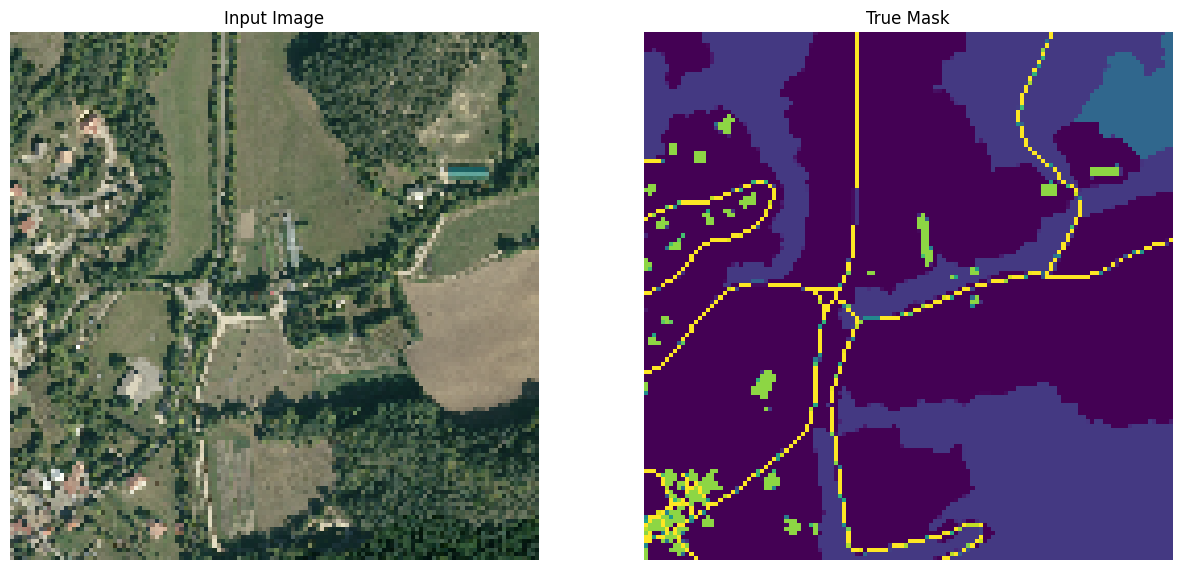

HINT: If the data does not fit into the memory, try by patching the image into smaller portions.

## Downloading the data

The data can be either downloaded from the link above and uploaded directly on Colab, or by running the following code snippet, that automatically downloads the data and unzip it.

In [ ]:
  !gdown 1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem
  !unzip ign_dataset.zip
  !rm ign_dataset.zip
  


## Multi-class segmentation

In this project, the input-target pair is composed by a $1000 \times 1000$ RGB image as visualized above, together with a $1000 \times 1000$ mask, that classifies each pixel by assigning to it a real number.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob

X_path = './ign/images/'
Y_path = './ign/annotations/'

train_name = sorted(os.listdir(os.path.join(X_path, 'training')))
test_name = sorted(os.listdir(os.path.join(X_path, 'validation')))

# As an example: load a sample to check the data
x_sample = plt.imread(os.path.join(X_path, 'training', train_name[20]))
y_sample = plt.imread(os.path.join(Y_path, 'training', train_name[20]))

print(f"Shape of x: {x_sample.shape}. Shape of y: {y_sample.shape}.")
print(f"Unique values of y: {np.unique(y_sample)}.")

Shape of x: (1000, 1000, 3). Shape of y: (1000, 1000).
Unique values of y: [0.         0.00392157 0.00784314 0.01176471 0.02352941].


In the example above, $\texttt{y_sample}$ contains 3 classes, represented by the three unique real numbers $[0, 0.00392157, 0.02352941]$.

Note that this approach is unusual in multiclass segmentation, where usually the mask is reshaped to be an $height \times width \times num. class$ binary array, where the pixel in position $(i, j)$ is classified as the class associated to the value 1, among the channels.

In this project, we assume that your data is processed as described above, since the metric used for the evaluation is implemented this way.  

## Metrics
The comparison metric for this project is the Dice Cofficient for multi-class segmentation (see the Lab about Segmentation for more informations). To apply this function, you are required to reshape both the predicted mask and the true mask to shape $\texttt{(batch_size, h, w, num_classes)}$, where $\text{num_classes}$ is the number of segmentation classes.

**IMPORTANT**: Remember to leave a print of average Dice Coefficient among the test set on the Notebook for a comparison. To do that, just measure the Dice Coffient by using the functions below for each batch, and take the average.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels = 7):
   dice=0
   for index in range(numLabels):
       dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
   return dice/numLabels

We defined also a dice coefficent function to be use as metrics during the training of the model

In [6]:
def dice_coef_for_training(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])  
    y_pred_f = tf.reshape(y_pred, [-1])  
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_multilabel_for_training(y_true, y_pred, numLabels=7):
    dice = 0
    for index in range(numLabels):
         dice += dice_coef_for_training(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice / numLabels

## Project implementation


### Data visualization 

First of all, we have decided to implement a data visualization function to gain a clearer understanding of how the data is stored in the dataset. This will also be useful later when comparing the predicted data with the test data

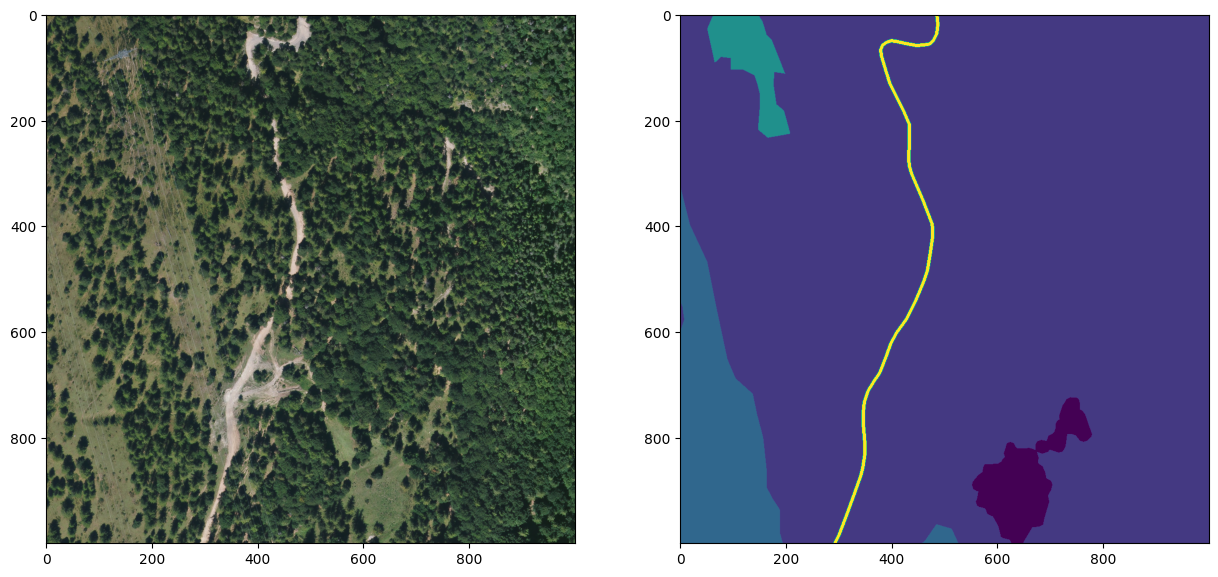

In [ ]:
def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y)
    if title:
        plt.title(title[1])

    plt.show()

show(x_sample, y_sample)

### Data Load and Reshape

While loading the data we also resize them to avoid  memory overflow.

In [7]:
def load_data_from_names(dir:str, root_dir: str, fnames: list) -> np.array:
    # Given the root path and a list of file names as input, return the dataset 
    # array.
    images = []
    for idx, img_name in enumerate(fnames):
        x = Image.open(os.path.join(root_dir ,dir, img_name))
        x = x.resize((256, 256), Image.Resampling.NEAREST)
        x = np.array(x, dtype=np.uint8) #casting to uint8 
        images.append(x)
    return np.array(images)

In [8]:
X_train = load_data_from_names("training",X_path, train_name)
Y_train = load_data_from_names("training",Y_path, train_name)

In [ ]:
X_test = load_data_from_names("validation",X_path, test_name)
Y_test = load_data_from_names("validation",Y_path, test_name)

In [ ]:
print(X_train.shape)
print(Y_train.shape)


(600, 256, 256, 3)
(600, 256, 256)


### Data Augmentation and One Hot Encoding

In [9]:
def apply_transform(x_data, y_data, T):
    N = x_data.shape[0]
    new_x_data = np.zeros_like(x_data)
    new_y_data = np.zeros_like(y_data)

    for i in range(N):
        new_x_data[i] = T(x_data[i])
        new_y_data[i] = T(y_data[i])
    return new_x_data, new_y_data

def augment_data(x_data: np.array, y_data: np.array, transforms: list) -> np.array:
    new_x_data = x_data
    new_y_data = y_data

    for T in transforms:
        new_x, new_y = apply_transform(x_data, y_data, T)

        new_x_data = np.concatenate([new_x_data, new_x], axis=0)
        new_y_data = np.concatenate([new_y_data, new_y], axis=0)
    return new_x_data, new_y_data

transforms = [np.flipud, np.fliplr]
X_train, Y_train = augment_data(X_train, Y_train, transforms)

As required we convert the Y_training and Y_training vectors using the one hot encoding notation.

In [10]:
Y_train_tr = ks.utils.to_categorical(Y_train)


In [23]:
Y_test_tr = ks.utils.to_categorical(Y_test)

In [8]:
num_classes = Y_train_tr.shape[-1]

In [37]:
num_classes

7

In [13]:
Y_train_tr.shape

(1800, 256, 256, 7)

### Model

We tried different models, and the one that yielded the best results in our case, while staying within the 10 million parameter limit, was the UNET

In [10]:
from keras.callbacks import ReduceLROnPlateau


In [11]:
def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):
    
    C = ks.layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = ks.layers.BatchNormalization()(C)
    C = ks.layers.Activation("relu")(C)
    C = ks.layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = ks.layers.BatchNormalization()(C)
    C = ks.layers.Activation("relu")(C)

    skip_connection = C  # Set aside residual
    
    # if max_pooling is True, add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = ks.layers.MaxPooling2D(pool_size=(2, 2))(C)        
    else:
        next_layer = C
            
    return next_layer, skip_connection

In [12]:
def decoding_block(inputs, skip_connection_input, filters):

    CT = ks.layers.Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)
    
    residual_connection = ks.layers.concatenate([CT, skip_connection_input], axis=3)

    C = ks.layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = ks.layers.BatchNormalization()(C)
    C = ks.layers.Activation("relu")(C)
    
    C = ks.layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = ks.layers.BatchNormalization()(C)
    C = ks.layers.Activation("relu")(C)
    return C


In [13]:
def create_unet(input_size, filters, num_classes):
    inputs = ks.Input(input_size)
        
    # Contracting Path (encoding)
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)
    
    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)
    
    # Expanding Path (decoding)
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)
    C10 = ks.layers.Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(U9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    C11 = ks.layers.Conv2D(filters = num_classes, kernel_size = (1,1), activation='softmax', padding='same')(C10)
    
    model = ks.Model(inputs=inputs, outputs=C11)

    return model

In [15]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
FILTERS = 32

model = create_unet((HEIGHT, WIDTH, CHANNELS), filters=FILTERS, num_classes=num_classes)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [dice_coef_multilabel_for_training])
batch_size = 16
epochs = 50

We divided the training into 3 steps to save weights after 50-25-25 epochs of computation. In the last step, we also implemented the 'reduce learning rate on plateau' callback

In [22]:
model.fit(X_train, 
                    Y_train_tr, 
                    epochs = epochs, 
                    verbose=1, 
                    batch_size = batch_size, 
                    validation_split=0.1,
                    shuffle = True)

Epoch 1/50
102/102 [==============================] - 81s 450ms/step - loss: 0.8755 - dice_coef_multilabel_for_training: 0.2397 - val_loss: 3.8723 - val_dice_coef_multilabel_for_training: 0.2264
Epoch 2/50
102/102 [==============================] - 41s 400ms/step - loss: 0.7722 - dice_coef_multilabel_for_training: 0.2712 - val_loss: 2.2267 - val_dice_coef_multilabel_for_training: 0.1374
Epoch 3/50
102/102 [==============================] - 40s 397ms/step - loss: 0.7197 - dice_coef_multilabel_for_training: 0.2990 - val_loss: 4.9169 - val_dice_coef_multilabel_for_training: 0.1156
Epoch 4/50
102/102 [==============================] - 42s 414ms/step - loss: 0.6993 - dice_coef_multilabel_for_training: 0.3091 - val_loss: 1.1249 - val_dice_coef_multilabel_for_training: 0.2296
Epoch 5/50
102/102 [==============================] - 41s 405ms/step - loss: 0.6857 - dice_coef_multilabel_for_training: 0.3213 - val_loss: 0.6765 - val_dice_coef_multilabel_for_training: 0.3326
Epoch 6/50
102/102 [=====

In [23]:
model.save_weights("unet_weights.h5")

In [19]:
epochs = 25

In [20]:
model.fit(X_train, 
                    Y_train_tr, 
                    epochs = epochs, 
                    verbose=1, 
                    batch_size = batch_size, 
                    validation_split=0.1,
                    shuffle = True)

Epoch 1/25
102/102 [==============================] - 84s 483ms/step - loss: 0.3915 - dice_coef_multilabel_for_training: 0.5074 - val_loss: 0.5731 - val_dice_coef_multilabel_for_training: 0.4425 - lr: 0.0010
Epoch 2/25
102/102 [==============================] - 43s 422ms/step - loss: 0.3933 - dice_coef_multilabel_for_training: 0.5107 - val_loss: 0.5390 - val_dice_coef_multilabel_for_training: 0.4642 - lr: 0.0010
Epoch 3/25
102/102 [==============================] - 42s 412ms/step - loss: 0.3725 - dice_coef_multilabel_for_training: 0.5242 - val_loss: 0.5268 - val_dice_coef_multilabel_for_training: 0.4776 - lr: 0.0010
Epoch 4/25
102/102 [==============================] - 43s 424ms/step - loss: 0.3639 - dice_coef_multilabel_for_training: 0.5311 - val_loss: 0.5511 - val_dice_coef_multilabel_for_training: 0.4641 - lr: 0.0010
Epoch 5/25
102/102 [==============================] - 42s 412ms/step - loss: 0.3596 - dice_coef_multilabel_for_training: 0.5401 - val_loss: 0.5721 - val_dice_coef_multi

In [21]:
model.save_weights("unet_weights_step2.h5")

In [18]:
reduce_lr = ks.callbacks.ReduceLROnPlateau(monitor="val_dice_coef_multilabel_for_training", patience=5)
epochs = 25

In [19]:
model.fit(X_train, 
                    Y_train_tr, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [reduce_lr],
                    batch_size = batch_size, 
                    validation_split=0.1,
                    shuffle = True)

Epoch 1/25
102/102 [==============================] - 83s 472ms/step - loss: 0.2573 - dice_coef_multilabel_for_training: 0.6206 - val_loss: 0.6951 - val_dice_coef_multilabel_for_training: 0.4947 - lr: 0.0010
Epoch 2/25
102/102 [==============================] - 43s 423ms/step - loss: 0.2461 - dice_coef_multilabel_for_training: 0.6338 - val_loss: 0.6364 - val_dice_coef_multilabel_for_training: 0.4997 - lr: 0.0010
Epoch 3/25
102/102 [==============================] - 44s 436ms/step - loss: 0.2470 - dice_coef_multilabel_for_training: 0.6270 - val_loss: 0.6408 - val_dice_coef_multilabel_for_training: 0.4912 - lr: 0.0010
Epoch 4/25
102/102 [==============================] - 44s 429ms/step - loss: 0.2501 - dice_coef_multilabel_for_training: 0.6287 - val_loss: 0.6480 - val_dice_coef_multilabel_for_training: 0.5054 - lr: 0.0010
Epoch 5/25
102/102 [==============================] - 44s 433ms/step - loss: 0.2282 - dice_coef_multilabel_for_training: 0.6455 - val_loss: 0.6846 - val_dice_coef_multi

In [21]:
model.save_weights("unet_weights_step3.h5")

### Prediction

In [24]:
Y_pred = model.predict(X_test)

7/7 [==============================] - 14s 743ms/step


Since the UNET provides probabilities for each pixel's membership in one of the 7 classes, we select the class with the highest probability and then apply one-hot encoding. This enables us to compare our predictions with the one-hot encoded ground truth Y for evaluation

In [25]:
Y_pred_enc = ks.utils.to_categorical(np.argmax(Y_pred, axis = -1))

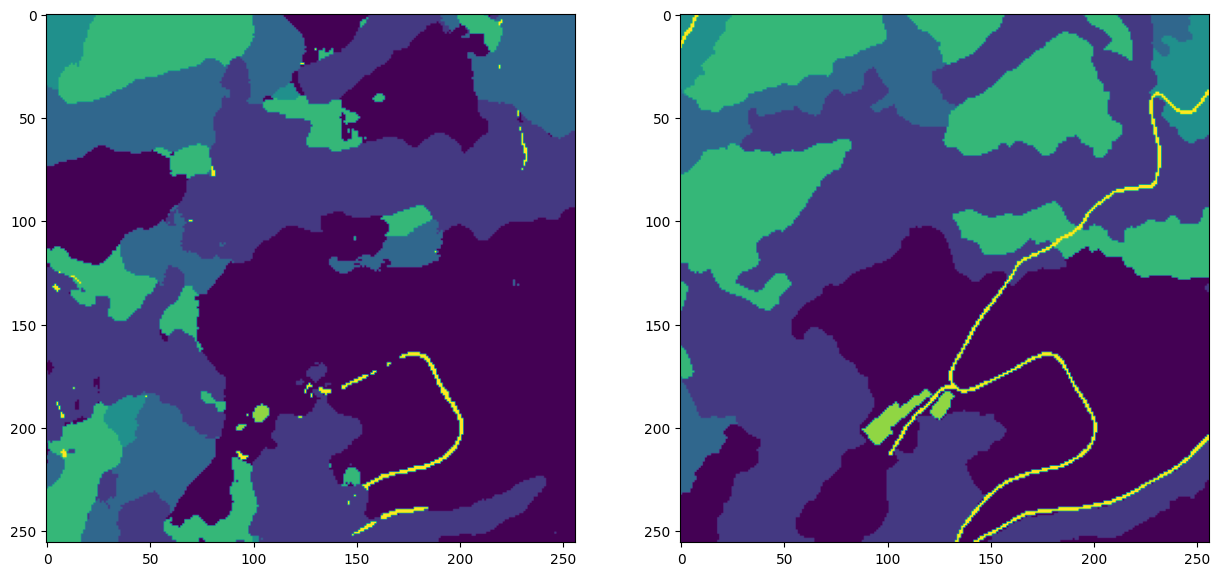

In [35]:
show(np.argmax(Y_pred[18], axis = 2),np.argmax(Y_test_tr, axis = 3)[18])

### Model Evaluation

In [27]:
dice = dice_coef_multilabel(Y_pred_enc,Y_test_tr, 7)
print(f"The Dice coefficient of the trained model is {dice}")

The Dice coefficient of the trained model is 0.5828094027313241
